# Imports

In [1]:
import numpy as np
from unicodedata import normalize
from pprint import pprint
import string
import re
import matplotlib.pyplot as plt
from keras.backend import clear_session
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, CuDNNLSTM, Input, Embedding, TimeDistributed, Flatten, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


# Reading movie lines

In [2]:
table = str.maketrans('', '', string.punctuation)
# prepare regex for char filtering
re_print = re.compile('[^%s]' % re.escape(string.printable))
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)

def clean_sentence(line):
    line = line.strip().replace('--', '').replace("  ", " ").replace('"', "")
    line = normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')
    # tokenize on white space
    line = line.split()
    # convert to lowercase
    line = [word.lower() for word in line]
    # remove punctuation from each token
    line = [word.translate(table) for word in line]
    # remove non-printable chars form each token
    line = [re_print.sub('', w) for w in line]
    # remove tokens with numbers in them
    line = [word for word in line if word.isalpha()]
    return ' '.join(line)

with open('./cornell-movie-dialogs-corpus/movie_lines.txt', 'r', errors='ignore') as f:
    lines_as_list = [row.strip() for row in f.readlines()]


lines = {}
for line in lines_as_list:
    lines[
        line.split('+++$+++')[0].strip()
    ] = clean_sentence(line.split('+++$+++')[-1])  # clean sentences

del lines_as_list

with open('./cornell-movie-dialogs-corpus/movie_conversations.txt', 'r', errors='ignore') as f:
    conversations = [row.strip() for row in f.readlines()]

# only take id's and convert list as string to list as list
conversations = [
    conversation.split('+++$+++')[-1].strip().replace('[', '').replace(']', '').replace("'", '').replace(" ", '').split(',') 
    for conversation in conversations
]

pprint({k: lines[k] for k in list(lines)[:10]})
print()
pprint(conversations[:10])

assert len([conversation for conversation in conversations if len(conversation) <=1]) == 0


{'L1044': 'they do to',
 'L1045': 'they do not',
 'L869': 'like my fear of wearing pastels',
 'L870': 'im kidding you know how sometimes you just become this persona and '
         'you dont know how to quit',
 'L871': 'no',
 'L872': 'okay youre gonna need to learn how to lie',
 'L924': 'wow',
 'L925': 'lets go',
 'L984': 'she okay',
 'L985': 'i hope so'}

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208'],
 ['L271', 'L272', 'L273', 'L274', 'L275'],
 ['L276', 'L277'],
 ['L280', 'L281'],
 ['L363', 'L364'],
 ['L365', 'L366']]


# map keys to line

In [3]:
conversations_with_lines = []
for conversation in conversations:
    conversations_with_lines.append([lines[key] for key in conversation])
    
pprint(conversations_with_lines[100:110])

[['yeah', 'what do you think'],
 ['two legs nice rack',
  'yeah whatever i want you to go out with her',
  'sure sparky ill get right on it',
  'you just said',
  'you need money to take a girl out',
  'but youd go out with her if you had the cake'],
 ['you got it verona i pick up the tab you do the honors',
  'youre gonna pay me to take out some girl',
  'i cant date her sister until that one gets a boyfriend and thats the catch '
  'she doesnt want a boyfriend',
  'how much'],
 ['i cant take a girl like that out on twenty bucks', 'fine thirty'],
 ['take it or leave it this isnt a negotiation',
  'fifty and youve got your man'],
 ['when i shell out fifty i expect results',
  'im on it',
  'watching the bitch trash my car doesnt count as a date',
  'i got her under control she just acts crazed in public to keep up the '
  'image'],
 ['i just upped my price',
  'what',
  'a hundred bucks a date',
  'forget it',
  'forget her sister then'],
 ['its about time', 'a deals a deal'],
 ['howd 

# Pair those things

In [4]:
def pair_it(my_list):
    pairs = []
    for i in range(len(my_list) -1):
        pairs.append([my_list[i], my_list[i + 1]])
    return pairs

paired_conversations_agg = [
    pair_it(conversation) for conversation in conversations_with_lines
]
conversations_pairs = np.array([item for sublist in paired_conversations_agg for item in sublist])
for i in range(10):
    pprint(conversations_pairs[i])

array(['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
       'well i thought wed start with pronunciation if thats okay with you'],
      dtype='<U2857')
array(['well i thought wed start with pronunciation if thats okay with you',
       'not the hacking and gagging and spitting part please'],
      dtype='<U2857')
array(['not the hacking and gagging and spitting part please',
       'okay then how bout we try out some french cuisine saturday night'],
      dtype='<U2857')
array(['youre asking me out thats so cute whats your name again',
       'forget it'], dtype='<U2857')
array(['no no its my fault we didnt have a proper introduction',
       'cameron'], dtype='<U2857')
array(['cameron',
       'the thing is cameron im at the mercy of a particularly hideous breed of loser my sister i cant date until she does'],
      dtype='<U2857')
array(['the thing is cameron im at the mercy of a particularly hideou

# Noise reduction

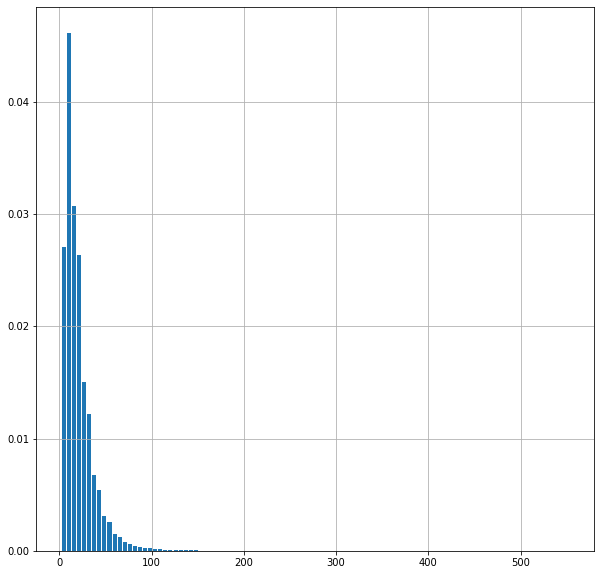

longest conversation: 
['what'
 'then lets begin with the story itself its a story of the grail mythand although there are several variations my favorite begins with the fisher king as a young boy who had to spend a night alone in the forest to prove his courage and during that night he is visited by a sacred vision out of the fire appears the holy grail gods highest symbol of divine grace and a voice says to the boy you shall be the guardian of the grail that it may heal the hearts of menbut the boy was overcome innocent and foolish he was blinded by greater visions a life ahead filled with beauty and glory hope and powertears filled his eyes as he sensed his own invincibility a boys tears of naive wonder and inspiration and in this state ofradical amazementhe felt for a brief moment not like a boy but like god and so he reached into the fire to take the grail and the grail vanished and the boy hands were left caught in the flamesleaving him wounded and ashamed at what his recklessnes

In [5]:
hist, edges  = np.histogram([len(question.split(' ')) + len(answer.split(' ')) for question, answer in conversations_pairs], density=True, bins=100)
center = (edges[:-1] + edges[1:]) / 2
f, ax = plt.subplots(figsize=(10, 10))
plt.bar(center, hist, align='center', width=(edges[1] - edges[0]) * .8)
plt.grid()
plt.show()

longest_converastion = conversations_pairs[np.array([len(question.split(' ')) + len(answer.split(' ')) for question, answer in conversations_pairs]).argmax()]
print("longest conversation: \n{}".format(longest_converastion))
print("\nlongest conversation has {} words".format(len(longest_converastion[0].split(' ')) + len(longest_converastion[1].split(' '))))
max_conversation_lenght = 38  # maximum alowed converastion lenght in words
clensed_conversations = np.array([conversation_pair for conversation_pair in conversations_pairs  if (len(conversation_pair[0].split(' ')) + len(conversation_pair[1].split(' '))) < max_conversation_lenght])
print("filetered {} conversations".format(len(conversations_pairs) - len(clensed_conversations)))

# Shity magic

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
    return np.array(
        [to_categorical(sequence, num_classes=vocab_size) for sequence in sequences]
    ).reshape(sequences.shape[0], sequences.shape[1], vocab_size)

all_lines = clensed_conversations.reshape(-1)
my_tokenizer = Tokenizer()
my_tokenizer.fit_on_texts(all_lines)
vocab_size = len(my_tokenizer.word_index) + 1
max_sentence_lenght = max(len(line.split()) for line in all_lines)
print('max sentence lenght: {} words'.format(max_sentence_lenght))

split_index = int(len(clensed_conversations) * .8)
train = clensed_conversations[:split_index]
test = clensed_conversations[split_index:]

# prepare training data
trainX = encode_sequences(my_tokenizer, max_sentence_lenght, train[:, 1])
trainY = encode_sequences(my_tokenizer, max_sentence_lenght, train[:, 0])
trainY = encode_output(trainY, vocab_size)
# prepare validation data
testX = encode_sequences(my_tokenizer, max_sentence_lenght, test[:, 1])
testY = encode_sequences(my_tokenizer, max_sentence_lenght, test[:, 0])
testY = encode_output(testY, vocab_size)

max sentence lenght: 36 words


# Define Model

In [7]:
clear_session()
n_units=256
model = Sequential()
model.add(Embedding(num_tokens, n_units, input_length=max_sentence_lenght, mask_zero=True))
model.add(LSTM(n_units))  # CuDNNLSTM
model.add(RepeatVector(max_sentence_lenght))
model.add(LSTM(n_units, return_sequences=True))  # CuDNNLSTM
model.add(TimeDistributed(Dense(num_tokens, activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 397, 256)          6912      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 397, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 397, 256)          525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 397, 27)           6939      
Total params: 1,064,475
Trainable params: 1,064,475
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
# fit model
filename = 'mount-this/model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)

In [8]:
model = load_model('chatbot-seq-400.h5')

In [20]:
to_infer = 'how are you'
source = np.zeros(max_sentence_lenght)

for i in range(len(to_infer)):
    source[i] = token_index[to_infer[i]]
source = source.reshape((1, source.shape[0]))
res = model.predict(source)
sentence = "".join([input_characters[np.argmax(char_indxes)] for char_indxes in res[0]])
print(to_infer + " -> " + sentence.strip())

how are you -> fi e
